In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/MIMIC/mimic_cxr-IV.zip -d /content/train_images_folder

Streaming output truncated to the last 5000 lines.
  inflating: /content/train_images_folder/re_512_3ch/Train/s59521988.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59521996.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522022.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522128.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522228.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522366.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522423.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522427.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522605.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522677.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522723.jpg  
  inflating: /content/train_images_folder/re_512_3ch/Train/s59522888.jpg  
  inflating: /content/train_images_folder/re_512_

In [ ]:
#!pip install monai

In [ ]:
import torch
import cv2
import torchvision.transforms as transforms
import tensorflow as tf
import numpy as np
#from monai.networks.nets import DenseNet121
import os
import json
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn.functional as F
from sklearn.metrics import f1_score
import random
import statistics

In [ ]:
train_json_path = "/content/drive/MyDrive/MIMIC/train_data.json"
unique_labels_path = "/content/drive/MyDrive/MIMIC/unique_labels.json"
images_folder = "/content/train_images_folder/re_512_3ch/Train"
output_folder = "/content/Train_dataset"

os.makedirs(output_folder, exist_ok=True)

with open(train_json_path, "r") as f:
    train_data = json.load(f)

with open(unique_labels_path, "r") as f:
    unique_labels = json.load(f)

label_to_index = {label: i for i, label in enumerate(unique_labels)}

dataset = []
for entry in tqdm(train_data, desc="Processing JSON entries"):
    image_id = entry["id"]
    labels = entry["label"].strip("'").split("', '") if entry["label"] else []

    if not labels:
        continue

    label_vector = np.zeros(len(unique_labels), dtype=np.float32)
    for label in labels:
        if label in label_to_index:
          label_vector[label_to_index[label]] = 1

    image_path = os.path.join(images_folder, f"{image_id}.jpg")
    if os.path.exists(image_path):
        with Image.open(image_path) as img:

            img_gray = img.convert("L")

            output_image_path = os.path.join(output_folder, f"{image_id}.jpg")
            img_gray.save(output_image_path)

            dataset.append({"image_path": output_image_path, "label_vector": label_vector.tolist(), "counter": 0})

dataset_json_path = os.path.join(output_folder, "dataset.json")
with open(dataset_json_path, "w") as f:
    json.dump(dataset, f)

print(f"Processed dataset saved at {output_folder}")

Processing JSON entries: 100%|██████████| 89395/89395 [05:23<00:00, 276.25it/s]


Processed dataset saved at /content/Train_dataset


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data_json, transform=None, sample_size=9000, seed=42):
        if sample_size and len(data_json) > sample_size:
            random.seed(seed)
            self.data = random.sample(data_json, sample_size)
        else:
            self.data = data_json

        self.transform = transform

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):
        img_path = self.data[idx]['image_path']
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.data[idx]['label_vector'], dtype=torch.float16)
        """
        old = new
        float32 = float16
        """
        #counter = torch.tensor(self.data[idx]['counter'], dtype=torch.float32)

        return image, label

In [ ]:
with open('/content/Train_dataset/dataset.json', 'r') as f:
    dataset_json = json.load(f)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
dataset = CustomDataset(dataset_json, transform=transform)

NameError: name 'dataset_json' is not defined

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F

"""
class Agent(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=728, nhead=8, num_layers=10, dim_feedforward=512, dropout=0.5):
        super(Agent, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Project input to d_model
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)  # Final classifier layer

    def forward(self, x):
        # Add positional encoding to input embeddings
        x = self.embedding(x)
        x = self.transformer_encoder(x.unsqueeze(1))  # Add sequence dimension
        x = x.mean(dim=1)  # Aggregate over sequence dimension
        return self.classifier(x)

"""

'\nclass Agent(nn.Module):\n    def __init__(self, input_dim, num_classes, d_model=728, nhead=8, num_layers=10, dim_feedforward=512, dropout=0.5):\n        super(Agent, self).__init__()\n        self.embedding = nn.Linear(input_dim, d_model)  # Project input to d_model\n        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)\n        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)\n        self.classifier = nn.Linear(d_model, num_classes)  # Final classifier layer\n\n    def forward(self, x):\n        # Add positional encoding to input embeddings\n        x = self.embedding(x)\n        x = self.transformer_encoder(x.unsqueeze(1))  # Add sequence dimension\n        x = x.mean(dim=1)  # Aggregate over sequence dimension\n        return self.classifier(x)\n\n'

In [ ]:
import torch
import torch.nn as nn
from timm.models import create_model
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

class TinyViTClassifier(nn.Module):
    def __init__(self, num_classes=14):
        super(TinyViTClassifier, self).__init__()
        # Load a pretrained Tiny ViT model from timm
        self.vit = create_model(
            'vit_tiny_patch16_224',  # Tiny ViT with patch size 16
            pretrained=True,
            num_classes=num_classes
        )

        # Add a channel expansion layer for grayscale inputs
        self.expand_channels = nn.Conv2d(1, 3, kernel_size=1)

    def forward(self, x):
        # Expand grayscale input to 3 channels
        x = self.expand_channels(x)
        #x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        # Forward pass through the Vision Transformer
        x = self.vit(x)
        return x

In [ ]:
class TinyViTevaluation(nn.Module):
    def __init__(self, num_classes=3):
        super(TinyViTevaluation, self).__init__()
        # Load a pretrained Tiny ViT model from timm
        self.vit = create_model(
            'vit_tiny_patch16_224',  # Tiny ViT with patch size 16
            pretrained=True,
            num_classes=num_classes
        )

        # Add a channel expansion layer for grayscale inputs
        self.expand_channels = nn.Conv2d(1, 3, kernel_size=1)

    def forward(self, x):
        # Expand grayscale input to 3 channels
        x = self.expand_channels(x)
        #x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        # Forward pass through the Vision Transformer
        x = self.vit(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
"""
embedding_model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=512, pretrained=True).to(device)
"""

'\nembedding_model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=512, pretrained=True).to(device)\n'

In [ ]:
model_val = TinyViTevaluation(num_classes=3).to(device) ########### change
model_class = TinyViTClassifier(num_classes=14).to(device)

val_optimizer = torch.optim.Adam(model_val.parameters(), lr=0.0001) #weight_decay = 1e-2
model_optimizer = torch.optim.Adam(model_class.parameters(), lr=0.0001)

criterion = nn.BCEWithLogitsLoss()
criterion_E = nn.CrossEntropyLoss()  # Agent(evaluation)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import Subset
import random

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, test_size])

NameError: name 'dataset' is not defined

In [ ]:
print(len(train_dataset), len(val_dataset))

7200 1800


In [ ]:
from torch.utils.data import Subset
import random

# شافل کردن اندیس‌ها
indices1 = list(range(len(train_dataset)))
random.seed(42)  # برای reproducibility
random.shuffle(indices1)


# شافل کردن اندیس‌ها
indices2 = list(range(len(val_dataset)))
random.seed(42)  # برای reproducibility
random.shuffle(indices2)

# ساختن دیتاست شافل‌شده
train_dataset = Subset(train_dataset, indices1)
val_dataset = Subset(val_dataset, indices2)

In [ ]:
print(len(train_dataset), len(val_dataset))

7200 1800


In [ ]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'train_dataset' is not defined

In [ ]:
import torch.nn.functional as F
from collections import Counter
from sklearn.mixture import GaussianMixture
import numpy as np

epochs = 35

# DataLoader بدون shuffle برای حفظ ترتیب تصاویر


for epoch in range(epochs):
    print("=" * 80)
    print(f"Epoch {epoch+1}/{epochs}")
    print("-" * 80)

    # ----------- مرحله اول: آموزش مدل ۱۴ کلاسه و استخراج loss ----------- #
    model_class.train()
    loss_list = []

    total_loss_class = 0
    total_samples = 0

    # برای داده‌های train
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_class(images)
        loss = criterion(outputs, labels)

        model_optimizer.zero_grad()
        loss.backward()
        model_optimizer.step()

        total_loss_class += loss.item() * images.size(0)
        total_samples += images.size(0)

        # ذخیره‌ی loss برای هر تصویر
        with torch.no_grad():
            preds = model_class(images)
            per_sample_loss = F.binary_cross_entropy_with_logits(preds, labels, reduction='none')
            loss_per_image = per_sample_loss.sum(dim=1).cpu().numpy().tolist()
            loss_list.extend(loss_per_image)

    avg_loss_class_train = total_loss_class / total_samples


    # ----------- مرحله دوم: خوشه‌بندی GMM روی lossها ----------- #
    loss_array = np.array(loss_list).reshape(-1, 1)
    gmm = GaussianMixture(n_components=3, random_state=42).fit(loss_array)
    cluster_ids = gmm.predict(loss_array)

    means = gmm.means_.flatten()
    sorted_clusters = np.argsort(means)
    cluster_to_difficulty = {sorted_clusters[0]: 0, sorted_clusters[1]: 1, sorted_clusters[2]: 2}
    difficulty_labels = [cluster_to_difficulty[c] for c in cluster_ids]

    # گزارش آماری خوشه‌ها
    counter = Counter(difficulty_labels)



    difficulty_labels_tensor = torch.tensor(difficulty_labels, dtype=torch.long).to(device)

    # ----------- مرحله سوم: آموزش مدل ارزش‌گذاری (۳ کلاس) ----------- #
    model_val.train()
    total_loss_val = 0
    idx = 0

    # برای داده‌های train
    for images, _ in train_loader:
        images = images.to(device)
        batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
        idx += images.size(0)

        outputs = model_val(images)
        loss_val = criterion_E(outputs, batch_labels)

        val_optimizer.zero_grad()
        loss_val.backward()
        val_optimizer.step()

        total_loss_val += loss_val.item() * images.size(0)

    avg_loss_val_train = total_loss_val / len(difficulty_labels)

    # ----------- مرحله چهارم: ارزیابی مدل‌ها روی داده‌های validation ----------- #
    """
    # مدل کلاسفیکیشن روی داده‌های validation
    model_class.eval()
    total_loss_class_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_class(images)
            loss = criterion(outputs, labels)

            total_loss_class_val += loss.item() * images.size(0)
            total_samples_val += images.size(0)
    """
    #avg_loss_class_val = total_loss_class_val / total_samples_val
    print(f"Average classification loss (14-class model) on train: {avg_loss_class_train:.4f}")
    #print(f"Average classification loss (14-class model) on validation: {avg_loss_class_val:.4f}")


    print("\nClustering losses with GMM...")
    print("\nCluster distribution:")
    for d in [0, 1, 2]:
        count = counter[d]
        percent = 100 * count / len(difficulty_labels)
        print(f"  Difficulty {d} → {count} samples ({percent:.2f}%)")
    """
    # مدل ارزش‌گذاری روی داده‌های validation
    model_val.eval()
    total_loss_val_eval = 0
    idx = 0

    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
            idx += images.size(0)

            outputs = model_val(images)
            loss_val = criterion_E(outputs, batch_labels)

            total_loss_val_eval += loss_val.item() * images.size(0)
    """
    #avg_loss_val_eval = total_loss_val_eval / len(difficulty_labels)
    print(f"\nAverage Evaluation loss (3-class model) on train: {avg_loss_val_train:.4f}")
    #print(f"Average Evaluation loss (3-class model) on validation: {avg_loss_val_eval:.4f}")

    print("=" * 80 + "\n")



final_epochs = 10
for final_epoch in range(final_epochs):
    print(f"\nFinal Epoch {final_epoch + 1}/{final_epochs}")
    model_val.train()
    total_loss_val = 0
    idx = 0

    for images, _ in train_loader:
        images = images.to(device)
        batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
        idx += images.size(0)

        outputs = model_val(images)
        loss_val = criterion_E(outputs, batch_labels)

        val_optimizer.zero_grad()
        loss_val.backward()
        val_optimizer.step()

        total_loss_val += loss_val.item() * images.size(0)

    avg_final_train_loss = total_loss_val / len(difficulty_labels)
    """
    # ارزیابی روی validation
    model_val.eval()
    total_val_loss = 0
    idx = 0

    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
            idx += images.size(0)

            outputs = model_val(images)
            loss_val = criterion_E(outputs, batch_labels)

            total_val_loss += loss_val.item() * images.size(0)
    """
    #avg_final_val_loss = total_val_loss / len(difficulty_labels)

    print(f"Train Loss: {avg_final_train_loss:.4f}")

Epoch 1/35
--------------------------------------------------------------------------------
Average classification loss (14-class model) on train: 0.3462

Clustering losses with GMM...

Cluster distribution:
  Difficulty 0 → 3716 samples (51.61%)
  Difficulty 1 → 2894 samples (40.19%)
  Difficulty 2 → 590 samples (8.19%)

Average Evaluation loss (3-class model) on train: 0.9089

Epoch 2/35
--------------------------------------------------------------------------------
Average classification loss (14-class model) on train: 0.3316

Clustering losses with GMM...

Cluster distribution:
  Difficulty 0 → 3159 samples (43.88%)
  Difficulty 1 → 3135 samples (43.54%)
  Difficulty 2 → 906 samples (12.58%)

Average Evaluation loss (3-class model) on train: 0.9779

Epoch 3/35
--------------------------------------------------------------------------------
Average classification loss (14-class model) on train: 0.3123

Clustering losses with GMM...

Cluster distribution:
  Difficulty 0 → 2810 sampl

In [ ]:
# Save Models
torch.save(model_class.state_dict(), '/content/drive/MyDrive/MIMIC2/models/model_classifier.pth')
torch.save(model_val.state_dict(), '/content/drive/MyDrive/MIMIC2/models/model_evaluation.pth')

In [ ]:
features_list = []
labels_list = []

model_val.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        images_rgb = model_val.expand_channels(images)  # تبدیل به ۳ کانال
        feats = model_val.vit.forward_features(images_rgb)
        preds = model_val(images).argmax(dim=1)

        features_list.append(feats.cpu())
        labels_list.append(preds.cpu())

features_tensor = torch.cat(features_list, dim=0).numpy()
labels_tensor = torch.cat(labels_list, dim=0).numpy()

In [ ]:
print(features_tensor[:, 0, :].shape)
print(len(labels_tensor))

(7200, 192)
7200


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(features_tensor[:, 0, :], labels_tensor)
dbi_score = davies_bouldin_score(features_tensor[:, 0, :], labels_tensor)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Silhouette Score: 0.4984
Davies-Bouldin Index: 0.9780


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
feats_2d = tsne.fit_transform(features_tensor[:, 0, :])

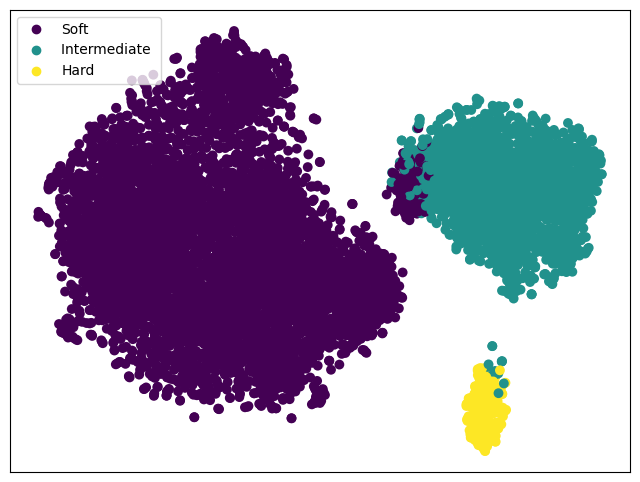

In [ ]:
import matplotlib.pyplot as plt

# رسم نمودار
plt.figure(figsize=(8, 6))  # تنظیم اندازه نمودار
scatter = plt.scatter(
    feats_2d[:, 0],
    feats_2d[:, 1],
    c=labels_tensor,
    cmap='viridis',      # پالت رنگی
    s=50,                # اندازه نقاط
    edgecolor='none'     # حذف لبه نقاط
)

# حذف اعداد محورها
plt.xticks([])  # حذف اعداد محور x
plt.yticks([])  # حذف اعداد محور y

# افزودن لجند
unique_label = ['Soft', 'Intermediate ', 'Hard']
# فرض بر این است که labels_tensor شامل اعداد صحیح (0, 1, 2, ...) است که هر عدد نماینده یک کلاس است.
unique_labels = sorted(set(labels_tensor))  # کلاس‌های منحصر به فرد
legend_labels = [f"{label}" for label in unique_label]  # برچسب‌های متنی برای هر کلاس
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# حذف خطوط دور نمودار (اختیاری)
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# افزودن عنوان و برچسب‌ها (اختیاری)
#plt.title("t-SNE Visualization", fontsize=14, pad=20)
#plt.colorbar(label='Classes')  # نمایش نوار رنگی برای برچسب‌ها

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# اجرای t-SNE با ۳ مولفه
tsne = TSNE(n_components=3, random_state=42)
feats_3d = tsne.fit_transform(features_tensor[:, 0, :])  # یا features_flattened

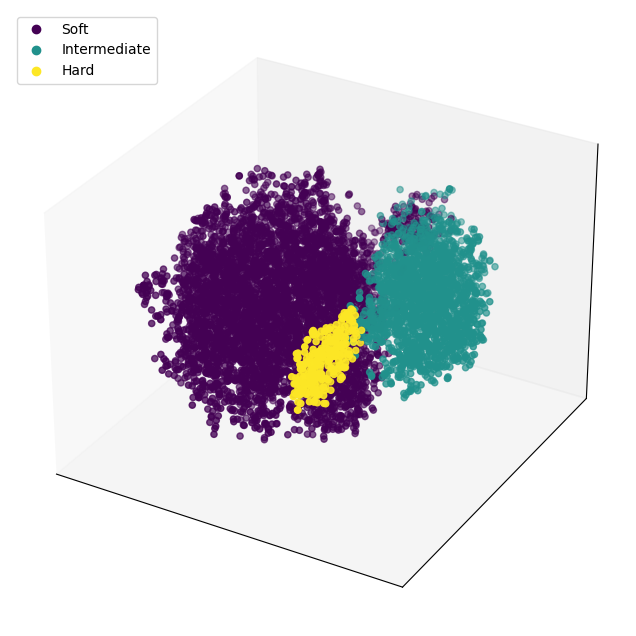

In [ ]:
# ایجاد شکل و محور سه‌بعدی
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# رسم نمودار سه‌بعدی
scatter = ax.scatter(
    feats_3d[:, 0],
    feats_3d[:, 1],
    feats_3d[:, 2],
    c=labels_tensor,
    cmap='viridis',
    s=20
)

# حذف اعداد محورها
ax.set_xticks([])  # حذف اعداد محور x
ax.set_yticks([])  # حذف اعداد محور y
ax.set_zticks([])  # حذف اعداد محور z

# افزودن لجند
unique_labels = ['Soft', 'Intermediate', 'Hard']  # نام‌های کلاس‌ها
legend_elements = scatter.legend_elements()[0]  # عناصر گرافیکی برای لجند
ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# نمایش نمودار
plt.show()

In [ ]:
features_list1 = []
labels_list1 = []

model_val.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)

        images_rgb = model_val.expand_channels(images)  # تبدیل به ۳ کانال
        feats = model_val.vit.forward_features(images_rgb)
        preds = model_val(images).argmax(dim=1)

        features_list1.append(feats.cpu())
        labels_list1.append(preds.cpu())

features_tensor1 = torch.cat(features_list1, dim=0).numpy()
labels_tensor1 = torch.cat(labels_list1, dim=0).numpy()
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score1 = silhouette_score(features_tensor1[:, 0, :], labels_tensor1)
dbi_score1 = davies_bouldin_score(features_tensor1[:, 0, :], labels_tensor1)

print(f"Silhouette Score: {sil_score1:.4f}")
print(f"Davies-Bouldin Index: {dbi_score1:.4f}")

Silhouette Score: 0.3484
Davies-Bouldin Index: 0.9054


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
feats_2d1 = tsne.fit_transform(features_tensor1[:, 0, :])

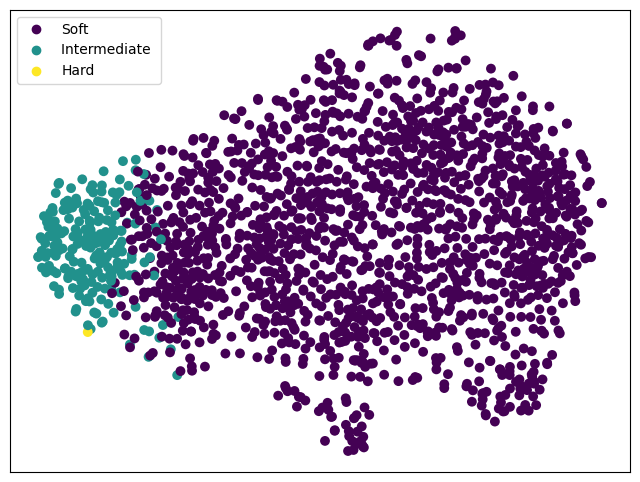

In [ ]:
import matplotlib.pyplot as plt

# رسم نمودار
plt.figure(figsize=(8, 6))  # تنظیم اندازه نمودار
scatter = plt.scatter(
    feats_2d1[:, 0],
    feats_2d1[:, 1],
    c=labels_tensor1,
    cmap='viridis',      # پالت رنگی
    s=50,                # اندازه نقاط
    edgecolor='none'     # حذف لبه نقاط
)

# حذف اعداد محورها
plt.xticks([])  # حذف اعداد محور x
plt.yticks([])  # حذف اعداد محور y

# افزودن لجند
unique_label = ['Soft', 'Intermediate ', 'Hard']
# فرض بر این است که labels_tensor شامل اعداد صحیح (0, 1, 2, ...) است که هر عدد نماینده یک کلاس است.
unique_labels = sorted(set(labels_tensor))  # کلاس‌های منحصر به فرد
legend_labels = [f"{label}" for label in unique_label]  # برچسب‌های متنی برای هر کلاس
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# حذف خطوط دور نمودار (اختیاری)
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# افزودن عنوان و برچسب‌ها (اختیاری)
#plt.title("t-SNE Visualization", fontsize=14, pad=20)
#plt.colorbar(label='Classes')  # نمایش نوار رنگی برای برچسب‌ها

plt.show()

In [ ]:
# اجرای t-SNE با ۳ مولفه
tsne = TSNE(n_components=3, random_state=42)
feats_3d1 = tsne.fit_transform(features_tensor1[:, 0, :])  # یا features_flattened

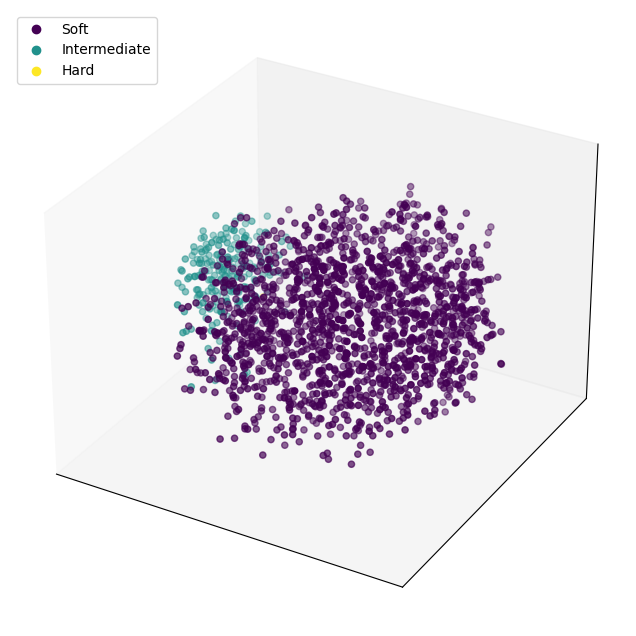

In [ ]:
from matplotlib import pyplot as plt

# ایجاد شکل و محور سه‌بعدی
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# رسم نمودار سه‌بعدی
scatter = ax.scatter(
    feats_3d1[:, 0],
    feats_3d1[:, 1],
    feats_3d1[:, 2],
    c=labels_tensor1,
    cmap='viridis',
    s=20
)

# حذف اعداد محورها
ax.set_xticks([])  # حذف اعداد محور x
ax.set_yticks([])  # حذف اعداد محور y
ax.set_zticks([])  # حذف اعداد محور z

# افزودن لجند
unique_labels = ['Soft', 'Intermediate', 'Hard']  # نام‌های کلاس‌ها
legend_elements = scatter.legend_elements()[0]  # عناصر گرافیکی برای لجند
ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# نمایش نمودار
plt.show()

In [ ]:
"""
final_epochs = 10
for final_epoch in range(final_epochs):
    print(f"\nFinal Epoch {final_epoch + 1}/{final_epochs}")
    model_val.train()
    total_loss_val = 0
    idx = 0

    for images, _ in train_loader:
        images = images.to(device)
        batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
        idx += images.size(0)

        outputs = model_val(images)
        loss_val = criterion_E(outputs, batch_labels)

        val_optimizer.zero_grad()
        loss_val.backward()
        val_optimizer.step()

        total_loss_val += loss_val.item() * images.size(0)

    avg_final_train_loss = total_loss_val / len(difficulty_labels)

    # ارزیابی روی validation
    model_val.eval()
    total_val_loss = 0
    idx = 0

    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
            idx += images.size(0)

            outputs = model_val(images)
            loss_val = criterion_E(outputs, batch_labels)

            total_val_loss += loss_val.item() * images.size(0)

    avg_final_val_loss = total_val_loss / len(difficulty_labels)

    print(f"Train Loss: {avg_final_train_loss:.4f} | Validation Loss: {avg_final_val_loss:.4f}")
torch.save(model_val.state_dict(), '/content/drive/MyDrive/MIMIC/Class_model_eval_img/model_evaluation1.pth')
"""


Final Epoch 1/10
Train Loss: 0.2516 | Validation Loss: 0.5409

Final Epoch 2/10
Train Loss: 0.2156 | Validation Loss: 0.4944

Final Epoch 3/10
Train Loss: 0.1970 | Validation Loss: 0.5433

Final Epoch 4/10
Train Loss: 0.2077 | Validation Loss: 0.5220

Final Epoch 5/10
Train Loss: 0.2144 | Validation Loss: 0.5786

Final Epoch 6/10
Train Loss: 0.2561 | Validation Loss: 0.5433

Final Epoch 7/10
Train Loss: 0.1524 | Validation Loss: 0.6434

Final Epoch 8/10
Train Loss: 0.1337 | Validation Loss: 0.5222

Final Epoch 9/10
Train Loss: 0.1331 | Validation Loss: 0.5588

Final Epoch 10/10
Train Loss: 0.1153 | Validation Loss: 0.5965


In [ ]:
"""
features_list = []
labels_list = []

model_val.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        images_rgb = model_val.expand_channels(images)  # تبدیل به ۳ کانال
        feats = model_val.vit.forward_features(images_rgb)
        preds = model_val(images).argmax(dim=1)

        features_list.append(feats.cpu())
        labels_list.append(preds.cpu())

features_tensor = torch.cat(features_list, dim=0).numpy()
labels_tensor = torch.cat(labels_list, dim=0).numpy()
"""

In [ ]:
"""
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(features_tensor[:, 0, :], labels_tensor)
dbi_score = davies_bouldin_score(features_tensor[:, 0, :], labels_tensor)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")
"""

Silhouette Score: 0.4017
Davies-Bouldin Index: 1.1391


In [ ]:
"""
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
feats_2d = tsne.fit_transform(features_tensor[:, 0, :])
"""

In [ ]:
"""
import matplotlib.pyplot as plt

# رسم نمودار
plt.figure(figsize=(8, 6))  # تنظیم اندازه نمودار
scatter = plt.scatter(
    feats_2d[:, 0],
    feats_2d[:, 1],
    c=labels_tensor,
    cmap='viridis',      # پالت رنگی
    s=50,                # اندازه نقاط
    edgecolor='none'     # حذف لبه نقاط
)

# حذف اعداد محورها
plt.xticks([])  # حذف اعداد محور x
plt.yticks([])  # حذف اعداد محور y

# افزودن لجند
unique_label = ['Soft', 'Intermediate ', 'Hard']
# فرض بر این است که labels_tensor شامل اعداد صحیح (0, 1, 2, ...) است که هر عدد نماینده یک کلاس است.
unique_labels = sorted(set(labels_tensor))  # کلاس‌های منحصر به فرد
legend_labels = [f"{label}" for label in unique_label]  # برچسب‌های متنی برای هر کلاس
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# حذف خطوط دور نمودار (اختیاری)
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# افزودن عنوان و برچسب‌ها (اختیاری)
#plt.title("t-SNE Visualization", fontsize=14, pad=20)
#plt.colorbar(label='Classes')  # نمایش نوار رنگی برای برچسب‌ها

plt.show()
"""

In [ ]:
"""
# اجرای t-SNE با ۳ مولفه
tsne = TSNE(n_components=3, random_state=42)
feats_3d = tsne.fit_transform(features_tensor[:, 0, :])  # یا features_flattened
"""

In [ ]:
"""
from matplotlib import pyplot as plt

# ایجاد شکل و محور سه‌بعدی
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# رسم نمودار سه‌بعدی
scatter = ax.scatter(
    feats_3d[:, 0],
    feats_3d[:, 1],
    feats_3d[:, 2],
    c=labels_tensor,
    cmap='viridis',
    s=20
)

# حذف اعداد محورها
ax.set_xticks([])  # حذف اعداد محور x
ax.set_yticks([])  # حذف اعداد محور y
ax.set_zticks([])  # حذف اعداد محور z

# افزودن لجند
unique_labels = ['Soft', 'Intermediate', 'Hard']  # نام‌های کلاس‌ها
legend_elements = scatter.legend_elements()[0]  # عناصر گرافیکی برای لجند
ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# نمایش نمودار
plt.show()
"""

In [ ]:
"""
features_list1 = []
labels_list1 = []

model_val.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)

        images_rgb = model_val.expand_channels(images)  # تبدیل به ۳ کانال
        feats = model_val.vit.forward_features(images_rgb)
        preds = model_val(images).argmax(dim=1)

        features_list1.append(feats.cpu())
        labels_list1.append(preds.cpu())

features_tensor1 = torch.cat(features_list1, dim=0).numpy()
labels_tensor1 = torch.cat(labels_list1, dim=0).numpy()
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score1 = silhouette_score(features_tensor1[:, 0, :], labels_tensor1)
dbi_score1 = davies_bouldin_score(features_tensor1[:, 0, :], labels_tensor1)

print(f"Silhouette Score: {sil_score1:.4f}")
print(f"Davies-Bouldin Index: {dbi_score1:.4f}")
"""

Silhouette Score: 0.2802
Davies-Bouldin Index: 1.5196


In [ ]:
"""
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score1 = silhouette_score(features_tensor1[:, 0, :], labels_tensor1)
dbi_score1 = davies_bouldin_score(features_tensor1[:, 0, :], labels_tensor1)

print(f"Silhouette Score: {sil_score1:.4f}")
print(f"Davies-Bouldin Index: {dbi_score1:.4f}")
"""

Silhouette Score: 0.2802
Davies-Bouldin Index: 1.5196


In [ ]:
"""
tsne = TSNE(n_components=2)
feats_2d1 = tsne.fit_transform(features_tensor1[:, 0, :])
"""

In [ ]:
"""
# رسم نمودار
plt.figure(figsize=(8, 6))  # تنظیم اندازه نمودار
scatter = plt.scatter(
    feats_2d1[:, 0],
    feats_2d1[:, 1],
    c=labels_tensor1,
    cmap='viridis',      # پالت رنگی
    s=50,                # اندازه نقاط
    edgecolor='none'     # حذف لبه نقاط
)

# حذف اعداد محورها
plt.xticks([])  # حذف اعداد محور x
plt.yticks([])  # حذف اعداد محور y

# افزودن لجند
unique_label = ['Soft', 'Intermediate ', 'Hard']
# فرض بر این است که labels_tensor شامل اعداد صحیح (0, 1, 2, ...) است که هر عدد نماینده یک کلاس است.
unique_labels = sorted(set(labels_tensor))  # کلاس‌های منحصر به فرد
legend_labels = [f"{label}" for label in unique_label]  # برچسب‌های متنی برای هر کلاس
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# حذف خطوط دور نمودار (اختیاری)
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# افزودن عنوان و برچسب‌ها (اختیاری)
#plt.title("t-SNE Visualization", fontsize=14, pad=20)
#plt.colorbar(label='Classes')  # نمایش نوار رنگی برای برچسب‌ها

plt.show()
"""

In [ ]:
"""
tsne = TSNE(n_components=3, random_state=42)
feats_3d1 = tsne.fit_transform(features_tensor1[:, 0, :])  # یا features_flattened
from matplotlib import pyplot as plt

# ایجاد شکل و محور سه‌بعدی
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# رسم نمودار سه‌بعدی
scatter = ax.scatter(
    feats_3d1[:, 0],
    feats_3d1[:, 1],
    feats_3d1[:, 2],
    c=labels_tensor1,
    cmap='viridis',
    s=20
)

# حذف اعداد محورها
ax.set_xticks([])  # حذف اعداد محور x
ax.set_yticks([])  # حذف اعداد محور y
ax.set_zticks([])  # حذف اعداد محور z

# افزودن لجند
unique_labels = ['Soft', 'Intermediate', 'Hard']  # نام‌های کلاس‌ها
legend_elements = scatter.legend_elements()[0]  # عناصر گرافیکی برای لجند
ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# نمایش نمودار
plt.show()
"""

In [ ]:
model_path = "/content/drive/MyDrive/MIMIC2/models/model_evaluation.pth"
model_val = TinyViTevaluation(num_classes=3).to(device)
checkpoint = torch.load(model_path, map_location=torch.device('cuda'))
model_val.load_state_dict(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
#!rm -rf /content/drive/MyDrive/MIMIC2/data/*

In [ ]:
import os
import csv
from torchvision.utils import save_image
from torch.utils.data import random_split

# مسیر ذخیره‌سازی تصاویر
output_base_dir = "/content/drive/MyDrive/MIMIC2/data"
os.makedirs(output_base_dir, exist_ok=True)
for i in range(3):
    os.makedirs(os.path.join(output_base_dir, f"class_{i}"), exist_ok=True)

# فایل CSV برای ذخیره مسیر تصاویر و برچسب‌ها
csv_path = os.path.join(output_base_dir, "labels.csv")
csv_file = open(csv_path, mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["filepath", "label"])  # عنوان ستون‌ها

# غیرفعال کردن گرادیان برای inference
model_val.eval()
with torch.no_grad():
    img_idx = 0  # شمارنده برای نام‌گذاری تصاویر

    for images, labels in train_loader:
        images = images.to(device)

        outputs = model_val(images)
        predicted_labels = torch.argmax(outputs, dim=1)  # گرفتن برچسب 0, 1, 2

        for i in range(images.size(0)):
            label = predicted_labels[i].item()
            class_dir = os.path.join(output_base_dir, f"class_{label}")
            img_filename = f"img_{img_idx}.png"
            save_path = os.path.join(class_dir, img_filename)

            save_image(images[i], save_path)
            csv_writer.writerow([save_path, labels[i]])
            img_idx += 1

csv_file.close()
print("ذخیره‌سازی تصاویر و برچسب‌ها تمام شد.")

ذخیره‌سازی تصاویر و برچسب‌ها تمام شد.


In [ ]:
#!rm -rf /content/drive/MyDrive/MIMIC/subset_data/*

In [ ]:
'''
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = int(self.data.iloc[idx, 1])

        image = Image.open(img_path).convert("L")  # چون grayscale هست

        if self.transform:
            image = self.transform(image)

        return image, label
'''

In [ ]:
'''
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

csv_path = "/content/drive/MyDrive/MIMIC/Class_model_eval/labels.csv"
dataset = CustomImageDataset(csv_file=csv_path, transform=transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
'''

In [ ]:
'''
import os
import random
import shutil
from sklearn.model_selection import train_test_split

input_dirs = {
    '0': '/content/drive/MyDrive/MIMIC/Class_model_eval/class_0',
    '1': '/content/drive/MyDrive/MIMIC/Class_model_eval/class_1',
    '2': '/content/drive/MyDrive/MIMIC/Class_model_eval/class_2',
}
subset_root = '/content/drive/MyDrive/MIMIC/subset'
os.makedirs(subset_root, exist_ok=True)

for class_label, dir_path in input_dirs.items():
    all_files = os.listdir(dir_path)
    sampled_files = random.sample(all_files, int(0.2 * len(all_files)))
    target_dir = os.path.join(subset_root, class_label)
    os.makedirs(target_dir, exist_ok=True)

    for file in sampled_files:
        src = os.path.join(dir_path, file)
        dst = os.path.join(target_dir, file)
        shutil.copy(src, dst)
'''

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/MIMIC2/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/MIMIC2/data/class_0',
    '1': '/content/drive/MyDrive/MIMIC2/data/class_1',
    '2': '/content/drive/MyDrive/MIMIC2/data/class_2',
}

subset_root = '/content/drive/MyDrive/MIMIC2/subset'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.9 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("90% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

90% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
#!rm -rf /content/drive/MyDrive/MIMIC2/subset/*

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = Image.open(img_path).convert('L')  # بارگذاری تصویر

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
############ subset learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/MIMIC2/subset/subset_labels.csv'
dataset = CustomDataset(csv_file=csv_path, transform=transform)
train_loader1 = DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
model1 = TinyViTClassifier(num_classes=14).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
criterion1 = nn.BCEWithLogitsLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# تقسیم مجموعه داده
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader1 = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader1 = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [ ]:
'''
import ast
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def process_labels(labels):
    labels = list(labels)
    for i in range(len(labels)):
        clean_str = labels[i].replace('\\n', '').strip()
        labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
    return torch.stack(labels)

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = process_labels(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion1(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc = "N/A (check if all classes are present)"

    return total_loss, acc, f1_macro, f1_micro, auc

# حلقه آموزش
for epoch in range(30):
    model1.train()
    total_loss = 0.0
    for inputs, labels in train_loader1:
        labels = process_labels(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer1.zero_grad()
        outputs = model1(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        total_loss += loss.item()

    # ارزیابی بر روی داده‌های آموزش
    _, train_acc, train_f1macro, train_f1micro, train_auc = evaluate_model(model1, train_loader1, dataset_name='train')

    # ارزیابی بر روی داده‌های اعتبارسنجی
    val_loss, val_acc, val_f1macro, val_f1micro, val_auc = evaluate_model(model1, val_loader, dataset_name='val')

    print(f"Epoch {epoch+1}/30")
    print(f"Train - Loss: {total_loss:.4f}, Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro:.4f}, AUC: {train_auc}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1_macro: {val_f1macro:.4f}, F1_micro: {val_f1micro:.4f}, AUC: {val_auc}")
    '''

'\nimport ast\nimport torch\nimport torch.nn.functional as F\nfrom sklearn.metrics import accuracy_score, f1_score, roc_auc_score\n\ndef process_labels(labels):\n    labels = list(labels)\n    for i in range(len(labels)):\n        clean_str = labels[i].replace(\'\\n\', \'\').strip()\n        labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)\n    return torch.stack(labels)\n\ndef evaluate_model(model, loader, dataset_name=None, threshold=0.5):\n    model.eval()\n    all_labels = []\n    all_preds = []\n    all_probs = []\n    total_loss = 0.0\n\n    with torch.no_grad():\n        for inputs, labels in loader:\n            labels = process_labels(labels)\n            inputs = inputs.to(device)\n            labels = labels.to(device)\n            outputs = model(inputs)\n            loss = criterion1(outputs, labels)\n            total_loss += loss.item()\n            probs = torch.sigmoid(outputs)\n            preds = (probs >= threshold).float()\n

In [ ]:
import ast
import re
for epoch in range(30):
    print(epoch)
    model1.train()
    total_loss = 0
    for inputs, labels in train_loader1:
        print('1')
        labels = list(labels)
        for i in range(len(labels)):
          clean_str = labels[i].replace('\\n', '').strip()
          # حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer1.zero_grad()
        outputs = model1(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 1/30 - Loss: 20.1501
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 2/30 - Loss: 18.7928
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 3/30 - Loss: 18.3877
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 4/30 - Loss: 17.8554
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 5/30 - Loss: 17.2349
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 6/30 - Loss: 16.0960
6
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 7/30 - Loss: 14.4152
7
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              clean_str = labels[i].replace('\\n', '').strip()
              # حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion1(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
        auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except ValueError:
        auc = "N/A (check if all classes are present)"

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model1, train_loader1, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model1, val_loader1, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: 1.0, AUC_micro: 1.0
Validation - Acc: 0.8146, F1: 0.2051, F1_micro: 0.39321789321789324, AUC_macro: 0.5908890956656977, AUC_micro: 0.7471131349639072


In [ ]:
###### Total Data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/MIMIC2/data/labels.csv'
dataset2 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader2 = DataLoader(dataset2, batch_size=128, shuffle=True)

In [ ]:
model2 = TinyViTClassifier(num_classes=14).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
criterion2 = nn.BCEWithLogitsLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
train_size2 = int(0.8 * len(dataset2))
test_size2 = len(dataset2) - train_size2

# تقسیم مجموعه داده
train_dataset2, test_dataset2 = random_split(dataset2, [train_size2, test_size2])
train_loader2 = DataLoader(train_dataset2, batch_size=100, shuffle=True)
val_loader2 = DataLoader(test_dataset2, batch_size=100, shuffle=True)

In [ ]:
print(len(train_dataset2), len(test_dataset2))

5760 1440


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re
for epoch in range(30):
    model2.train()
    total_loss = 0
    for inputs, labels in train_loader2:
      labels = list(labels)
      for i in range(len(labels)):
        clean_str = labels[i].replace('\\n', '').strip()
        # حالا تبدیل به لیست پایتون و سپس tensor
        labels[i] = torch.tensor(ast.literal_eval(clean_str[7:-29].strip()), dtype=torch.float32)
        #print(labels)
      labels = torch.stack(labels)
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer2.zero_grad()
      outputs = model2(inputs)
      loss = criterion2(outputs, labels)
      loss.backward()
      optimizer2.step()
      total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 22.5773
Epoch 2/30 - Loss: 21.1553
Epoch 3/30 - Loss: 20.6979
Epoch 4/30 - Loss: 20.1077
Epoch 5/30 - Loss: 19.4074
Epoch 6/30 - Loss: 18.5853
Epoch 7/30 - Loss: 17.1967
Epoch 8/30 - Loss: 15.3360
Epoch 9/30 - Loss: 13.0724
Epoch 10/30 - Loss: 10.3341
Epoch 11/30 - Loss: 7.5038
Epoch 12/30 - Loss: 5.2820
Epoch 13/30 - Loss: 3.4898
Epoch 14/30 - Loss: 2.1904
Epoch 15/30 - Loss: 1.3249
Epoch 16/30 - Loss: 0.8168
Epoch 17/30 - Loss: 0.5316
Epoch 18/30 - Loss: 0.3887
Epoch 19/30 - Loss: 0.3136
Epoch 20/30 - Loss: 0.2633
Epoch 21/30 - Loss: 0.2276
Epoch 22/30 - Loss: 0.1998
Epoch 23/30 - Loss: 0.1773
Epoch 24/30 - Loss: 0.1590
Epoch 25/30 - Loss: 0.1437
Epoch 26/30 - Loss: 0.1309
Epoch 27/30 - Loss: 0.1191
Epoch 28/30 - Loss: 0.1090
Epoch 29/30 - Loss: 0.1007
Epoch 30/30 - Loss: 0.0930


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              clean_str = labels[i].replace('\\n', '').strip()
              # حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(ast.literal_eval(clean_str[7:-29].strip()), dtype=torch.float32)
            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion2(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
        auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except ValueError:
        auc = "N/A (check if all classes are present)"

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro


_, train_acc1, train_f1macro1, train_f1micro1, train_auc_ma1, train_auc_mi1 = evaluate_model(model2, train_loader2, dataset_name='train')
print(f"Train - Acc: {train_acc1:.4f}, F1_macro: {train_f1macro1:.4f}, F1_micro: {train_f1micro1}, AUC_macro: {train_auc_ma1}, AUC_micro: {train_auc_mi1}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc1, val_f1macro1, val_f1micro1, val_auc_macro1, val_auc_micro1 = evaluate_model(model2, val_loader2, dataset_name='val')
print(f"Validation - Acc: {val_acc1:.4f}, F1: {val_f1macro1:.4f}, F1_micro: {val_f1micro1}, AUC_macro: {val_auc_macro1}, AUC_micro: {val_auc_micro1}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: 1.0, AUC_micro: 1.0
Validation - Acc: 0.8149, F1: 0.2032, F1_micro: 0.3881967213114754, AUC_macro: 0.5920927307687541, AUC_micro: 0.7519408069957386


# 80%

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/MIMIC2/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/MIMIC2/data/class_0',
    '1': '/content/drive/MyDrive/MIMIC2/data/class_1',
    '2': '/content/drive/MyDrive/MIMIC2/data/class_2',
}

subset_root = '/content/drive/MyDrive/MIMIC2/subset80'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.8 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("80% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

80% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
############ subset80 learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/MIMIC2/subset80/subset_labels.csv'
dataset3 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader3 = DataLoader(dataset3, batch_size=256, shuffle=True)

In [ ]:
model3 = TinyViTClassifier(num_classes=14).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001)
criterion3 = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset3))
test_size = len(dataset3) - train_size

# تقسیم مجموعه داده
train_dataset3, test_dataset3 = random_split(dataset3, [train_size, test_size])
train_loader3 = DataLoader(train_dataset3, batch_size=100, shuffle=True)
val_loader3 = DataLoader(test_dataset3, batch_size=100, shuffle=True)

In [ ]:
import ast
import re
for epoch in range(30):
    #print(epoch)
    model3.train()
    total_loss = 0
    for inputs, labels in train_loader3:
        #print('1')
        labels = list(labels)
        for i in range(len(labels)):
          clean_str = labels[i].replace('\\n', '').strip()
          # حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer3.zero_grad()
        outputs = model3(inputs)
        loss = criterion3(outputs, labels)
        loss.backward()
        optimizer3.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 17.7765
Epoch 2/30 - Loss: 17.1397
Epoch 3/30 - Loss: 16.7809
Epoch 4/30 - Loss: 16.5250
Epoch 5/30 - Loss: 16.1846
Epoch 6/30 - Loss: 15.5577
Epoch 7/30 - Loss: 14.6683
Epoch 8/30 - Loss: 13.6402
Epoch 9/30 - Loss: 12.4900
Epoch 10/30 - Loss: 10.9206
Epoch 11/30 - Loss: 8.7846
Epoch 12/30 - Loss: 7.7451
Epoch 13/30 - Loss: 5.5321
Epoch 14/30 - Loss: 3.7939
Epoch 15/30 - Loss: 2.6649
Epoch 16/30 - Loss: 1.5874
Epoch 17/30 - Loss: 1.0289
Epoch 18/30 - Loss: 0.6657
Epoch 19/30 - Loss: 0.5288
Epoch 20/30 - Loss: 0.4045
Epoch 21/30 - Loss: 0.3253
Epoch 22/30 - Loss: 0.2683
Epoch 23/30 - Loss: 0.2328
Epoch 24/30 - Loss: 0.2045
Epoch 25/30 - Loss: 0.1833
Epoch 26/30 - Loss: 0.1643
Epoch 27/30 - Loss: 0.1502
Epoch 28/30 - Loss: 0.1385
Epoch 29/30 - Loss: 0.1256
Epoch 30/30 - Loss: 0.1157


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              clean_str = labels[i].replace('\\n', '').strip()
              # حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion3(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
        auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except ValueError:
        auc = "N/A (check if all classes are present)"

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model3, train_loader3, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model3, val_loader3, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: 1.0, AUC_micro: 1.0
Validation - Acc: 0.8165, F1: 0.2091, F1_micro: 0.40562248995983935, AUC_macro: 0.589516342836002, AUC_micro: 0.7582067184435496


# 70%

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/MIMIC2/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/MIMIC2/data/class_0',
    '1': '/content/drive/MyDrive/MIMIC2/data/class_1',
    '2': '/content/drive/MyDrive/MIMIC2/data/class_2',
}

subset_root = '/content/drive/MyDrive/MIMIC2/subset70'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.7 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("70% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

70% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
############ subset70 learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/MIMIC2/subset70/subset_labels.csv'
dataset4 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader4 = DataLoader(dataset4, batch_size=256, shuffle=True)

In [ ]:
model4 = TinyViTClassifier(num_classes=14).to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.0001)
criterion4 = nn.BCEWithLogitsLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset4))
test_size = len(dataset4) - train_size

# تقسیم مجموعه داده
train_dataset4, test_dataset4 = random_split(dataset4, [train_size, test_size])
train_loader4 = DataLoader(train_dataset4, batch_size=100, shuffle=True)
val_loader4 = DataLoader(test_dataset4, batch_size=100, shuffle=True)

In [ ]:
import ast
import re
for epoch in range(30):
    #print(epoch)
    model4.train()
    total_loss = 0
    for inputs, labels in train_loader4:
        #print('1')
        labels = list(labels)
        for i in range(len(labels)):
          clean_str = labels[i].replace('\\n', '').strip()
          # حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer4.zero_grad()
        outputs = model4(inputs)
        loss = criterion4(outputs, labels)
        loss.backward()
        optimizer4.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 16.6472
Epoch 2/30 - Loss: 15.4434
Epoch 3/30 - Loss: 15.1657
Epoch 4/30 - Loss: 15.0037
Epoch 5/30 - Loss: 14.7387
Epoch 6/30 - Loss: 14.6546
Epoch 7/30 - Loss: 14.3474
Epoch 8/30 - Loss: 14.1970
Epoch 9/30 - Loss: 13.7691
Epoch 10/30 - Loss: 13.1819
Epoch 11/30 - Loss: 12.5964
Epoch 12/30 - Loss: 11.6053
Epoch 13/30 - Loss: 10.3432
Epoch 14/30 - Loss: 9.2213
Epoch 15/30 - Loss: 7.6700
Epoch 16/30 - Loss: 6.0678
Epoch 17/30 - Loss: 4.5604
Epoch 18/30 - Loss: 3.5076
Epoch 19/30 - Loss: 2.3259
Epoch 20/30 - Loss: 1.6799
Epoch 21/30 - Loss: 1.0299
Epoch 22/30 - Loss: 0.6579
Epoch 23/30 - Loss: 0.4551
Epoch 24/30 - Loss: 0.3508
Epoch 25/30 - Loss: 0.2916
Epoch 26/30 - Loss: 0.2486
Epoch 27/30 - Loss: 0.2189
Epoch 28/30 - Loss: 0.1950
Epoch 29/30 - Loss: 0.1765
Epoch 30/30 - Loss: 0.1601


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              clean_str = labels[i].replace('\\n', '').strip()
              # حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion4(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
        auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except ValueError:
        auc = "N/A (check if all classes are present)"

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model4, train_loader4, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model4, val_loader4, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: 1.0, AUC_micro: 1.0
Validation - Acc: 0.8184, F1: 0.1993, F1_micro: 0.3887431433341283, AUC_macro: 0.5631388662405169, AUC_micro: 0.7357372178209436


# 60%

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/MIMIC2/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/MIMIC2/data/class_0',
    '1': '/content/drive/MyDrive/MIMIC2/data/class_1',
    '2': '/content/drive/MyDrive/MIMIC2/data/class_2',
}

subset_root = '/content/drive/MyDrive/MIMIC2/subset60'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.6 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("60% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

60% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
############ subset60 learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/MIMIC2/subset60/subset_labels.csv'
dataset5 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader5 = DataLoader(dataset5, batch_size=256, shuffle=True)

In [ ]:
model5 = TinyViTClassifier(num_classes=14).to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.0001)
criterion5 = nn.BCEWithLogitsLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset5))
test_size = len(dataset5) - train_size

# تقسیم مجموعه داده
train_dataset5, test_dataset5 = random_split(dataset5, [train_size, test_size])
train_loader5 = DataLoader(train_dataset5, batch_size=100, shuffle=True)
val_loader5 = DataLoader(test_dataset5, batch_size=100, shuffle=True)

In [ ]:
import ast
import re
for epoch in range(30):
    #print(epoch)
    model5.train()
    total_loss = 0
    for inputs, labels in train_loader5:
        #print('1')
        labels = list(labels)
        for i in range(len(labels)):
          clean_str = labels[i].replace('\\n', '').strip()
          # حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer5.zero_grad()
        outputs = model5(inputs)
        loss = criterion5(outputs, labels)
        loss.backward()
        optimizer5.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 13.9168
Epoch 2/30 - Loss: 12.8760
Epoch 3/30 - Loss: 12.5644
Epoch 4/30 - Loss: 12.2906
Epoch 5/30 - Loss: 11.8287
Epoch 6/30 - Loss: 11.3120
Epoch 7/30 - Loss: 10.2163
Epoch 8/30 - Loss: 9.0696
Epoch 9/30 - Loss: 7.5002
Epoch 10/30 - Loss: 5.8412
Epoch 11/30 - Loss: 4.4441
Epoch 12/30 - Loss: 3.2545
Epoch 13/30 - Loss: 2.1609
Epoch 14/30 - Loss: 1.4200
Epoch 15/30 - Loss: 0.9367
Epoch 16/30 - Loss: 0.6304
Epoch 17/30 - Loss: 0.4506
Epoch 18/30 - Loss: 0.3477
Epoch 19/30 - Loss: 0.2863
Epoch 20/30 - Loss: 0.2447
Epoch 21/30 - Loss: 0.2145
Epoch 22/30 - Loss: 0.1912
Epoch 23/30 - Loss: 0.1715
Epoch 24/30 - Loss: 0.1559
Epoch 25/30 - Loss: 0.1427
Epoch 26/30 - Loss: 0.1305
Epoch 27/30 - Loss: 0.1202
Epoch 28/30 - Loss: 0.1115
Epoch 29/30 - Loss: 0.1040
Epoch 30/30 - Loss: 0.0966


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              clean_str = labels[i].replace('\\n', '').strip()
              # حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion5(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
        auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except ValueError:
        auc = "N/A (check if all classes are present)"

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model5, train_loader5, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model5, val_loader5, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: 1.0, AUC_micro: 1.0
Validation - Acc: 0.8124, F1: 0.1798, F1_micro: 0.36673178900362824, AUC_macro: 0.5435077302105438, AUC_micro: 0.7332449937901626


# 50%

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/MIMIC2/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/MIMIC2/data/class_0',
    '1': '/content/drive/MyDrive/MIMIC2/data/class_1',
    '2': '/content/drive/MyDrive/MIMIC2/data/class_2',
}

subset_root = '/content/drive/MyDrive/MIMIC2/subset50'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.5 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("50% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

50% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
############ subset50 learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/MIMIC2/subset50/subset_labels.csv'
dataset6 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader6 = DataLoader(dataset6, batch_size=256, shuffle=True)

In [ ]:
model6 = TinyViTClassifier(num_classes=14).to(device)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=0.0001)
criterion6 = nn.BCEWithLogitsLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset6))
test_size = len(dataset6) - train_size

# تقسیم مجموعه داده
train_dataset6, test_dataset6 = random_split(dataset6, [train_size, test_size])
train_loader6 = DataLoader(train_dataset6, batch_size=100, shuffle=True)
val_loader6 = DataLoader(test_dataset6, batch_size=100, shuffle=True)

In [ ]:
import ast
import re
for epoch in range(30):
    #print(epoch)
    model5.train()
    total_loss = 0
    for inputs, labels in train_loader6:
        #print('1')
        labels = list(labels)
        for i in range(len(labels)):
          clean_str = labels[i].replace('\\n', '').strip()
          # حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer6.zero_grad()
        outputs = model6(inputs)
        loss = criterion6(outputs, labels)
        loss.backward()
        optimizer6.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 11.6889
Epoch 2/30 - Loss: 10.8117
Epoch 3/30 - Loss: 10.4957
Epoch 4/30 - Loss: 10.2030
Epoch 5/30 - Loss: 9.8161
Epoch 6/30 - Loss: 9.3169
Epoch 7/30 - Loss: 8.4714
Epoch 8/30 - Loss: 7.4766
Epoch 9/30 - Loss: 6.2766
Epoch 10/30 - Loss: 4.9420
Epoch 11/30 - Loss: 3.5483
Epoch 12/30 - Loss: 2.5041
Epoch 13/30 - Loss: 1.6798
Epoch 14/30 - Loss: 1.1516
Epoch 15/30 - Loss: 0.7786
Epoch 16/30 - Loss: 0.5524
Epoch 17/30 - Loss: 0.4053
Epoch 18/30 - Loss: 0.3190
Epoch 19/30 - Loss: 0.2659
Epoch 20/30 - Loss: 0.2284
Epoch 21/30 - Loss: 0.2010
Epoch 22/30 - Loss: 0.1799
Epoch 23/30 - Loss: 0.1627
Epoch 24/30 - Loss: 0.1479
Epoch 25/30 - Loss: 0.1356
Epoch 26/30 - Loss: 0.1250
Epoch 27/30 - Loss: 0.1156
Epoch 28/30 - Loss: 0.1076
Epoch 29/30 - Loss: 0.1004
Epoch 30/30 - Loss: 0.0942


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              clean_str = labels[i].replace('\\n', '').strip()
              # حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion6(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
        auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except ValueError:
        auc = "N/A (check if all classes are present)"

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model6, train_loader6, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model6, val_loader6, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: 1.0, AUC_micro: 1.0
Validation - Acc: 0.8151, F1: 0.1967, F1_micro: 0.38237243207422134, AUC_macro: 0.5859061893910875, AUC_micro: 0.7489304270474625


In [ ]:
'''
  Accuracy, F1-score(macro), F1-score(micro), AUC(macro), AUC(micro)
'''
metrics = {
    50: [0.8151, 0.1967, 0.38237243207422134, 0.5859061893910875, 0.7489304270474625],
    60: [0.8124, 0.1798, 0.36673178900362824, 0.5435077302105438, 0.7332449937901626],
    70: [0.8184, 0.1993, 0.3887431433341283, 0.5631388662405169, 0.7357372178209436],
    80: [0.8165, 0.2091, 0.40562248995983935, 0.589516342836002, 0.7582067184435496],
    90: [0.8146, 0.2051, 0.39321789321789324, 0.5908890956656977, 0.7471131349639072],
    100: [0.8149, 0.2032, 0.3881967213114754, 0.5920927307687541, 0.7519408069957386]
}

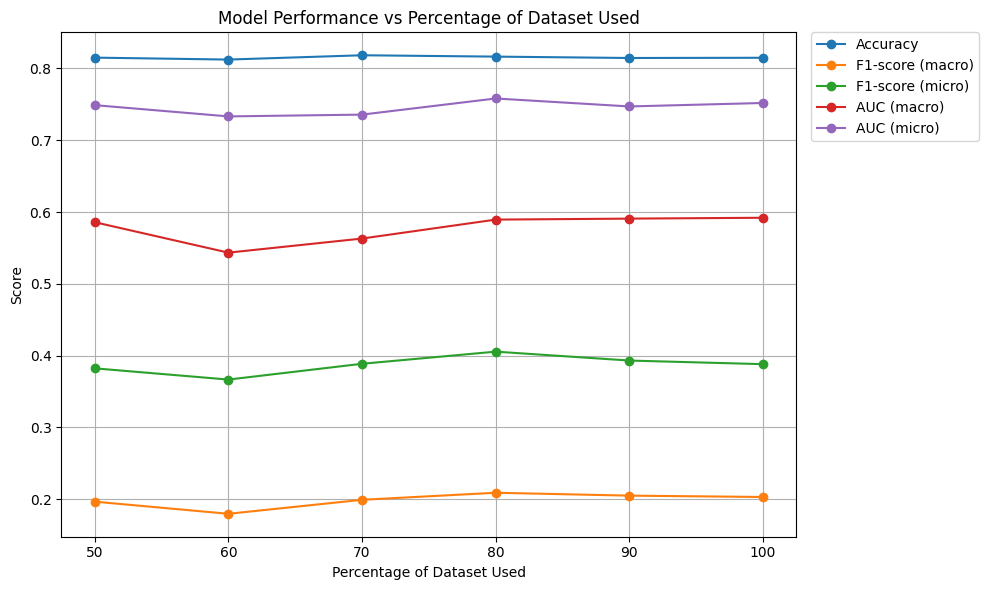

In [ ]:
import matplotlib.pyplot as plt
x = list(metrics.keys())
accuracy = [metrics[k][0] for k in x]
f1_macro = [metrics[k][1] for k in x]
f1_micro = [metrics[k][2] for k in x]
auc_macro = [metrics[k][3] for k in x]
auc_micro = [metrics[k][4] for k in x]

# رسم نمودار
plt.figure(figsize=(10, 6))
plt.plot(x, accuracy, marker='o', label='Accuracy')
plt.plot(x, f1_macro, marker='o', label='F1-score (macro)')
plt.plot(x, f1_micro, marker='o', label='F1-score (micro)')
plt.plot(x, auc_macro, marker='o', label='AUC (macro)')
plt.plot(x, auc_micro, marker='o', label='AUC (micro)')

# تنظیمات نمودار
plt.xlabel('Percentage of Dataset Used')
plt.ylabel('Score')
plt.title('Model Performance vs Percentage of Dataset Used')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid(True)
#plt.xlim(45, 115)
plt.tight_layout()
plt.show()